In [1]:
%matplotlib inline

from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import copy
from sklearn.model_selection import train_test_split
from hyperopt import hp
import imp

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation

RDKit WARNING: [11:47:40] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from modules.data import data_maker
from modules.RNN import double_RNN
from modules.fit import Model, fit, predict, mae, rmse, save_model
from modules.myhyperopt import hyperopt_func
from modules.MPNN import double_MPNN

/Users/u6676643/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


---
## Loading Dataset

In [3]:
data = pd.read_csv('data/full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
data_size = len(solute)

In [4]:
indices = list(range(data_size))
CV_ids, holdout_ids, _, _ = train_test_split(indices, solvent, test_size=0.2, random_state=1, stratify=solvent)
CV_datasets = data_maker(solute, solvent, pka, CV_ids)
datasets = data_maker(solute, solvent, pka)

---
## Training + testing

In [14]:
DMPNN = Model(name='D-MPNN',
              model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='ReLU', 
                                atom_messages=False, dropout=0, interaction=None, readout='sum'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
DMPNN_att = Model(name='D-MPNN with attention',
              model=double_MPNN(MP_depth=4, MP_hidden=128, NN_depth=4, NN_hidden=64, activation='ELU', 
                                atom_messages=False, dropout=0, interaction='tanh', readout='mean'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
MPNN = Model(name='MPNN',
             model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='LeakyReLU', 
                                  atom_messages=True, dropout=0, interaction=None, readout='sum'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
MPNN_att = Model(name='MPNN with attention',
             model=double_MPNN(MP_depth=2, MP_hidden=64, NN_depth=4, NN_hidden=512, activation='ReLU', 
                                  atom_messages=True, dropout=0, interaction='tanh', readout='max'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
RNN = Model(name='RNN',
            model=double_RNN(NN_depth=3, NN_hidden=512, RNN_hidden=512, activation='ReLU', dropout=0.3,
                             features=300, interaction=None, readout='max'),
            lr=0.001,
            batch_size=32,
            model_type='torch',
            data_type='sentences')
RNN_att = Model(name='RNN with attention',
                model=double_RNN(NN_depth=1, NN_hidden=1024, RNN_hidden=512, activation='PReLU', dropout=0.1,
                                 features=300, interaction='exp', readout='max'),
                lr=0.001,
                batch_size=32,
                model_type='torch',
                data_type='sentences')
RF_desc = Model(name='Random forest with descriptors',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='descriptors')
RF_ECFP = Model(name='Random forest with ECFP',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='ECFP')
MLP_desc = Model(name='MLP with descriptors',
                 model=MLPRegressor(activation='logistic', batch_size=32, early_stopping=True, hidden_layer_sizes=(512, 256, 128), solver='adam'),
                 model_type='sklearn',
                 data_type='descriptors')
MLP_ECFP = Model(name='MLP with ECFP',
                 model=MLPRegressor(activation='relu', batch_size=16, early_stopping=True, hidden_layer_sizes=(256, 128, 64), solver='adam'),
                 model_type='sklearn',
                 data_type='ECFP')
XGB_desc = Model(name='XGBoost with descriptors',
                 model=XGBRegressor(colsample_bytree=0.7, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.9),
                 model_type='sklearn',
                 data_type='descriptors')
XGB_ECFP = Model(name='XGBoost with ECFP',
                 model=XGBRegressor(colsample_bytree=0.6, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.8),
                 model_type='sklearn',
                 data_type='ECFP')
#list of all models for testing
#models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att, RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]
models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att]
#models = [RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]

In [15]:
#TODO: holdout data test
exp_name = "Holdout test"
results = ddict(list)
for m in models:
    print('testing '+m.name+' ...')
    data = datasets[m.data_type]
    
    res = fit(m, data, holdout_ids, exp_name)
    
    results['Model'].append(m.name)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])
    
    save_model(m, exp_name)

holdout_test = pd.DataFrame(results)
print(holdout_test)
holdout_test.to_csv('results/holdout_test.csv')

testing D-MPNN ...
testing D-MPNN with attention ...
testing MPNN ...
testing MPNN with attention ...
testing RNN ...
testing RNN with attention ...
                   Model   MAE  RMSE
0                 D-MPNN 1.010 1.581
1  D-MPNN with attention 1.102 1.657
2                   MPNN 1.090 1.729
3    MPNN with attention 1.093 1.495
4                    RNN 1.298 1.996
5     RNN with attention 1.181 1.719


D-MPNN


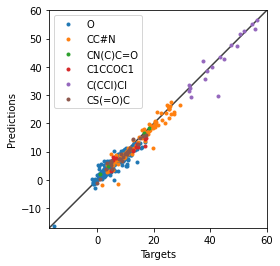

D-MPNN with attention


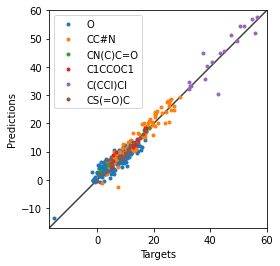

MPNN


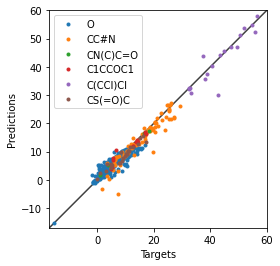

MPNN with attention


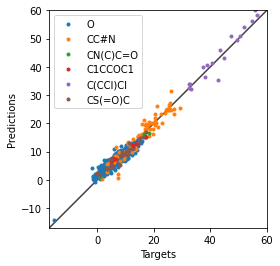

RNN


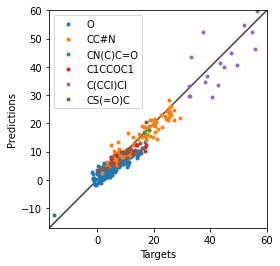

RNN with attention


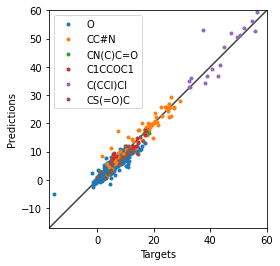

In [16]:
solv_set = list(set(solvent))
solv_ids = ddict()
for solv in solv_set:
    solv_ids[solv] = [i for i,x in enumerate(solvent) if x == solv and i in holdout_ids]
for m in models:
    print(m.name)
    for solv in solv_set:
        data = datasets[m.data_type]
        targets, outputs = predict(m, "Holdout test", data, solv_ids[solv])
        plt.plot(targets, outputs, 'o', markersize=3,label=solv)
        
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    lims = [-17,60]
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axes=plt.gca()
    axes.set_aspect('equal')
    axes.set_xlim(lims)
    axes.set_ylim(lims)
    axes.legend()
    plt.show()

In [17]:
#TODO: dataset size vs accuracy
results = ddict(list)
proportions = [0.1,0.2,0.5,0.75]

for prop in proportions:
    solvents = [solvent[i] for i in CV_ids]
    train_ids,_,_,_ = train_test_split(CV_ids, solvents, test_size=1-prop, random_state=1, stratify=solvents)
    train_size = len(train_ids)
    exp_name = "Training data size "+str(prop)
    print('testing prop '+str(prop)+' ...')
    for m in models:
        data = datasets[m.data_type]

        res = fit(m, data, holdout_ids, exp_name, train_ids=train_ids)

        results['Model'].append(m.name)
        results['Train size'].append(train_size)
        results['MAE'].append(res[0])
        results['RMSE'].append(res[1])

train_size = len(CV_ids)
for m in models:
    data = datasets[m.data_type]

    res = fit(m, data, holdout_ids, exp_name, train_ids=CV_ids)

    results['Model'].append(m.name)
    results['Train size'].append(train_size)
    results['MAE'].append(res[0])
    results['RMSE'].append(res[1])

train_prop_test = pd.DataFrame(results)
print(train_prop_test)
train_prop_test.to_csv('results/train_prop_test.csv')

testing prop 0.1 ...
testing prop 0.2 ...
testing prop 0.5 ...
testing prop 0.75 ...
                    Model  Train size   MAE  RMSE
0                  D-MPNN         257 2.164 3.346
1   D-MPNN with attention         257 2.920 4.230
2                    MPNN         257 2.913 3.870
3     MPNN with attention         257 2.442 4.131
4                     RNN         257 2.378 3.789
5      RNN with attention         257 2.059 3.105
6                  D-MPNN         515 1.523 2.388
7   D-MPNN with attention         515 1.949 3.008
8                    MPNN         515 1.700 2.553
9     MPNN with attention         515 1.634 2.629
10                    RNN         515 2.047 3.125
11     RNN with attention         515 1.677 2.522
12                 D-MPNN        1288 1.482 2.487
13  D-MPNN with attention        1288 1.536 2.647
14                   MPNN        1288 1.460 2.297
15    MPNN with attention        1288 1.603 2.466
16                    RNN        1288 1.575 2.440
17     RNN with

In [18]:
#LOSO
results = ddict(list)
solvent_set = list(set(solvent))

for solv in solvent_set:
    test_ids = [i for i, x in enumerate(solvent) if x == solv]
    size = len(test_ids)
    exp_name = "LOSO "+solv
    print('testing '+solv+' ...')
    for m in models:
        try:
            data = datasets[m.data_type]

            res = fit(m, data, test_ids, exp_name)

            results['Model'].append(m.name)
            results['LOSO solvent'].append(solv)
            results['Test size'].append(size)
            results['MAE'].append(res[0])
            results['RMSE'].append(res[1])
        except:
            print('error with model '+m.name)

LOSO_test = pd.DataFrame(results)
print(LOSO_test)
LOSO_test.to_csv('results/LOSO_test.csv')

testing O ...
testing CC#N ...
testing CN(C)C=O ...
testing C1CCOC1 ...
testing C(CCl)Cl ...
testing CS(=O)C ...
                    Model LOSO solvent  Test size    MAE   RMSE
0                  D-MPNN            O       2519  5.860  6.733
1   D-MPNN with attention            O       2519 15.483 16.529
2                    MPNN            O       2519  6.261  7.026
3     MPNN with attention            O       2519 14.815 15.748
4                     RNN            O       2519 11.215 12.263
5      RNN with attention            O       2519 12.801 13.437
6                  D-MPNN         CC#N        400  4.037  4.870
7   D-MPNN with attention         CC#N        400  4.774  5.878
8                    MPNN         CC#N        400  3.075  3.792
9     MPNN with attention         CC#N        400  4.238  5.127
10                    RNN         CC#N        400  5.602  6.522
11     RNN with attention         CC#N        400  7.880  8.795
12                 D-MPNN     CN(C)C=O         20  1.58

In [19]:
#LOEO
results = ddict(list)
element_set = ['N','O','F','P','S','Cl','Br']

for ele in element_set:
    test_ids = [i for i, x in enumerate(solute) if ele in x]
    size = len(test_ids)
    exp_name = "LOEO "+ele
    print('testing '+ele+' ...')
    for m in models:
        data = datasets[m.data_type]

        res = fit(m, data, test_ids, exp_name)

        results['Model'].append(m.name)
        results['LOEO element'].append(ele)
        results['Test size'].append(size)
        results['MAE'].append(res[0])
        results['RMSE'].append(res[1])

LOEO_test = pd.DataFrame(results)
print(LOEO_test)
LOEO_test.to_csv('results/LOEO_test.csv')

testing N ...
testing O ...
testing F ...
testing P ...
testing S ...
testing Cl ...
testing Br ...
                    Model LOEO element  Test size   MAE  RMSE
0                  D-MPNN            N       2311 3.438 4.853
1   D-MPNN with attention            N       2311 2.876 4.462
2                    MPNN            N       2311 4.371 5.539
3     MPNN with attention            N       2311 3.318 4.859
4                     RNN            N       2311 2.979 4.523
5      RNN with attention            N       2311 2.945 4.466
6                  D-MPNN            O       2067 3.100 4.299
7   D-MPNN with attention            O       2067 3.277 4.577
8                    MPNN            O       2067 3.656 4.982
9     MPNN with attention            O       2067 3.161 4.483
10                    RNN            O       2067 3.638 5.311
11     RNN with attention            O       2067 3.847 5.246
12                 D-MPNN            F        423 2.434 3.815
13  D-MPNN with attention       

In [ ]:
#LOMO
results = ddict(list)
solute_masses = [MolWt(Chem.MolFromSmiles(mol)) for mol in solute]
mass_cutoffs = [150,200,250,300,350]

for mass in mass_cutoffs:
    test_ids = [i for i, x in enumerate(solute_masses) if x > mass]
    size = len(test_ids)
    exp_name = "LOMO >"+str(mass)+'g/mol'
    print('testing >'+str(mass)+'g/mol ...')
    for m in models:
        try:
            data = datasets[m.data_type]

            res = fit(m, data, test_ids, exp_name)

            results['Model'].append(m.name)
            results['LOMO mass cutoff'].append(mass)
            results['Test size'].append(size)
            results['MAE'].append(res[0])
            results['RMSE'].append(res[1])
        except:
            print('error with model '+m.name)

LOMO_high_test = pd.DataFrame(results)
print(LOMO_high_test)
LOMO_high_test.to_csv('results/LOMO_high_test.csv')

testing >150g/mol ...
testing >200g/mol ...
testing >250g/mol ...
testing >300g/mol ...


In [ ]:
#LOMO
results = ddict(list)
solute_masses = [MolWt(Chem.MolFromSmiles(mol)) for mol in solute]
mass_cutoffs = [50,100,150,200,250,300,350]

for mass in mass_cutoffs:
    test_ids = [i for i, x in enumerate(solute_masses) if x < mass]
    size = len(test_ids)
    exp_name = "LOMO <"+str(mass)+'g/mol'
    print('testing <'+str(mass)+'g/mol ...')
    for m in models:
        try:
            data = datasets[m.data_type]

            res = fit(m, data, test_ids, exp_name)

            results['Model'].append(m.name)
            results['LOMO mass cutoff'].append(mass)
            results['Test size'].append(size)
            results['MAE'].append(res[0])
            results['RMSE'].append(res[1])
        except:
            print('error with model '+m.name)

LOMO_low_test = pd.DataFrame(results)
print(LOMO_low_test)
LOMO_low_test.to_csv('results/LOMO_low_test.csv')

In [ ]:
#LOCO
results = ddict(list)
solute_charges = [GetFormalCharge(Chem.MolFromSmiles(mol)) for mol in solute]
charge_list = [0,1]

for charge in charge_list:
    test_ids = [i for i, x in enumerate(solute_charges) if x == charge]
    size = len(test_ids)
    exp_name = "LOCO "+str(charge)
    print('testing >'+str(charge)+' ...')
    for m in models:
        try:
            data = datasets[m.data_type]

            res = fit(m, data, test_ids, exp_name)

            results['Model'].append(m.name)
            results['LOCO charge'].append(charge)
            results['Test size'].append(size)
            results['MAE'].append(res[0])
            results['RMSE'].append(res[1])
        except:
            print('error with model '+m.name)

LOCO_test = pd.DataFrame(results)
print(LOCO_test)
LOCO_test.to_csv('results/LOCO_test.csv')

In [ ]:
#LOFO
results = ddict(list)
pattern_list = [('proton donor','[!H0;F,Cl,Br,I,N+,$([OH]-*=[!#6]),+]'),
             ('H-bond donor','[N,n,O;!H0]'),
             ('protonated amine','[NH+,NH2+,NH3+,nH+,nH2+]'),
             ('carboxylic acid','[CX3](=O)[OX2H1]'),
             ('amide','[NX3][CX3](=[OX1])[#6]'),
             ('ketone','[#6][CX3](=O)[#6]'),
             ('ether','[OD2]([#6])[#6]'),
             ('amine','[NX3;H2,H1;!$(NC=O)]'),
             ('nitrile','[NX1]#[CX2]'),
             ('nitro','[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'),
             ('hydroxyl alcohol','[#6][OX2H]'),
             ('phenol','[OX2H][cX3]:[c]'),
             ('thiol','[#16X2H]'),
             ('phosphoric acid','[$(P(=[OX1])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)]),$([P+]([OX1-])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)])]')]
solute_mols = [Chem.MolFromSmiles(sol) for sol in solute]

for name, smart in pattern_list:
    patt = Chem.MolFromSmarts(smart)
    test_ids = [i for i, x in enumerate(solute_mols) if x.HasSubstructMatch(patt)==True]
    size = len(test_ids)
    exp_name = "LOFO "+name
    print('testing '+name+' ...')
    for m in models:
        try:
            data = datasets[m.data_type]

            res = fit(m, data, test_ids, exp_name)

            results['Model'].append(m.name)
            results['LOFO group'].append(name)
            results['Test size'].append(size)
            results['MAE'].append(res[0])
            results['RMSE'].append(res[1])
        except:
            print('error with model '+m.name)

LOFO_test = pd.DataFrame(results)
print(LOFO_test)
LOFO_test.to_csv('results/LOFO_test.csv')